# `dev`

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import nemo
import copy
import tqdm
import timeit
import shutil
import pathlib
import commons
import attrdict
import itertools
import numpy as np

from ruamel import yaml
from Bio import pairwise2
from nemo.collections import asr as nemo_asr
from nemo.collections.asr.helpers import post_process_predictions, post_process_transcripts, word_error_rate

## Reordering

In [16]:
NGC_MAP = '~/Downloads/librivox-train-all.json'
LOCAL_MAP = [
    '/home/stanislavv/data/nemo-librispeech/train_clean_100.json',
    '/home/stanislavv/data/nemo-librispeech/train_clean_360.json',
    '/home/stanislavv/data/nemo-librispeech/train_other_500.json',
]
AD_HOC_MAP = '/home/stanislavv/data/librispeech/train-all.json'

In [25]:
DATA_BASE = pathlib.Path('/home/stanislavv/data/librispeech')

NGC_BASE = DATA_BASE / 'ngc'
NGC = [
    NGC_BASE / 'librivox-dev-clean.json',
    NGC_BASE / 'librivox-dev-other.json',
    NGC_BASE / 'librivox-test-clean.json',
    NGC_BASE / 'librivox-test-other.json',
    NGC_BASE / 'librivox-train-all.json',
]

LOCAL_BASE = DATA_BASE / 'local'
LOCAL = [
    LOCAL_BASE / 'dev_clean.json',
    LOCAL_BASE / 'dev_other.json',
    LOCAL_BASE / 'test_clean.json',
    LOCAL_BASE / 'test_other.json',
    LOCAL_BASE / 'train_all.json',
]

NEW_LOCAL_BASE = DATA_BASE / 'new-local'
NEW_LOCAL = [
    NEW_LOCAL_BASE / 'dev-clean.json',
    NEW_LOCAL_BASE / 'dev-other.json',
    NEW_LOCAL_BASE / 'test-clean.json',
    NEW_LOCAL_BASE / 'test-other.json',
    NEW_LOCAL_BASE / 'train-all.json',
]

In [9]:
def get_ngc_id(audio_file):
    return os.path.basename(audio_file)[:-4]

In [23]:
def remap(ngc_map, local_map, new_file):
    order = [
        get_ngc_id(example['audio_file']) 
        for example in nemo.collections.asr.parts.manifest.item_iter(str(ngc_map))
    ]
    
    local_id_index = [
        (get_ngc_id(example['audio_file']), i)
        for i, example in enumerate(nemo.collections.asr.parts.manifest.item_iter(str(local_map)))
    ]
    
    local_id_index_dict = dict(local_id_index)
    new_order = [local_id_index_dict[id_] for id_ in order]

    lines = []
    with open(local_map, 'r') as f:
        lines.extend(list(f))
    lines = [lines[id_] for id_ in new_order]
    
    with open(new_file, 'w') as f:
        for line in lines:
            f.write(line)

In [24]:
for ngc, local, new_local in zip(NGC, LOCAL, NEW_LOCAL):
    remap(ngc, local, new_local)

## Preparation

In [179]:
MAP = '/home/stanislavv/data/ljspeech/local/split3/test.json'
SAMPLE_RATE = 22050

In [2]:
MAP = '/home/stanislavv/data/libritts/local-22k/train-all.json'
SAMPLE_RATE = 22050  # FROM LJSPEECH

In [171]:
runner = nemo.core.NeuralModuleFactory(
    placement=nemo.core.DeviceType.GPU,
)

In [4]:
MODEL_CONFIG = '/home/stanislavv/src/tts/NeMo/examples/asr/configs/quartznet15x5.yaml'
yaml_loader = yaml.YAML(typ="safe")
with open(MODEL_CONFIG) as f:
    config = attrdict.AttrDict(yaml_loader.load(f))
config.sample_rate = SAMPLE_RATE
# config['AudioToMelSpectrogramPreprocessor']['window_size'] = 1024
config['AudioToMelSpectrogramPreprocessor']['window_stride'] = None
config['AudioToMelSpectrogramPreprocessor']['n_window_stride'] = 256
# config['AudioToMelSpectrogramPreprocessor']['n_fft'] = 1024
labels = list(config.labels)
print(*labels)
config.AudioToMelSpectrogramPreprocessor

  a b c d e f g h i j k l m n o p q r s t u v w x y z '


AttrDict({'window_size': 0.02, 'window_stride': None, 'window': 'hann', 'normalize': 'per_feature', 'n_fft': 512, 'features': 64, 'dither': 1e-05, 'pad_to': 16, 'stft_conv': True, 'n_window_stride': 256})

In [6]:
MODEL_CONFIG = '/home/stanislavv/src/tts/NeMo/examples/tts/configs/fasterspeech.yaml'
yaml_loader = yaml.YAML(typ="safe")
with open(MODEL_CONFIG) as f:
    pp_config = attrdict.AttrDict(yaml_loader.load(f))
pp_config.sample_rate = SAMPLE_RATE
pp_config.AudioToMelSpectrogramPreprocessor

AttrDict({'dither': 0.0, 'features': 80, 'frame_splicing': 1, 'highfreq': 8000, 'log': True, 'log_zero_guard_type': 'clamp', 'log_zero_guard_value': 1e-05, 'lowfreq': 0, 'mag_power': 1.0, 'n_fft': 1024, 'n_window_size': 1024, 'n_window_stride': 256, 'normalize': None, 'pad_to': 16, 'pad_value': -11.52, 'preemph': None, 'sample_rate': 24000, 'stft_conv': True, 'window': 'hann', 'window_size': None, 'window_stride': None})

In [31]:
MODEL_CONFIG = '/home/stanislavv/src/tts/NeMo/examples/tts/configs/fasterspeech-mels-lj.yaml'
yaml_loader = yaml.YAML(typ='safe')
with open(MODEL_CONFIG) as f:
    gconfig = attrdict.AttrDict(yaml_loader.load(f))

gconfig.sample_rate = SAMPLE_RATE
print(*gconfig.labels)

  a b c d e f g h i j k l m n o p q r s t u v w x y z , . ! ? ; : - / " ' ( ) [ ] { }


In [180]:
data_layer = nemo_asr.AudioToTextDataLayer(
    manifest_filepath=MAP,
    sample_rate=config.sample_rate,
    labels=config.labels,
    batch_size=64,
    shuffle=False,
)
a, al, t, tl = next(iter(data_layer._dataloader))
a.shape, al.shape

[NeMo I 2020-04-28 17:40:21 collections:144] Dataset loaded with 300 files totalling 0.55 hours
[NeMo I 2020-04-28 17:40:21 collections:145] 0 files were filtered totalling 0.00 hours


(torch.Size([64, 221085]), torch.Size([64]))

In [181]:
# Full texts
ft = nemo_asr.AudioToTextDataLayer(
    manifest_filepath=MAP,
    sample_rate=config.sample_rate,
    labels=gconfig.labels,
    batch_size=64,
    shuffle=False,
)
FT = [e[2] for e in ft._dataset]
FT[:3]

[NeMo I 2020-04-28 17:40:22 collections:144] Dataset loaded with 300 files totalling 0.55 hours
[NeMo I 2020-04-28 17:40:22 collections:145] 0 files were filtered totalling 0.00 hours


[tensor([ 1,  6, 20,  5, 18,  0, 18,  5,  1,  4,  9, 14,  7,  0,  9, 20, 27,  0,
          1, 14,  4,  0,  6,  9, 14,  4,  9, 14,  7,  0, 20,  8,  9, 19,  0, 21,
         14,  6,  1, 22, 15, 18,  1,  2, 12,  5,  0, 20, 15,  0,  8,  9, 13, 19,
          5, 12,  6, 27,  0,  8,  5,  0, 18,  5, 19, 15, 12, 22,  5,  4,  0, 20,
         15,  0,  3,  1, 18, 18, 25,  0, 15, 21, 20,  0,  8,  9, 19,  0,  4,  5,
         12,  9,  2,  5, 18,  1, 20,  5,  0, 16, 12,  1, 14, 27]),
 tensor([ 9, 20,  0,  9, 19,  0,  3, 15, 14,  3,  5,  9, 22,  1,  2, 12,  5,  0,
         20,  8,  1, 20,  0, 20,  8, 15, 19,  5,  0, 13,  5, 14,  0, 23,  8, 15,
          0,  8,  1,  4,  0, 12,  9, 20, 20, 12,  5,  0, 19, 12,  5,  5, 16, 27,
          0,  1, 14,  4,  0, 23,  8, 15,  0,  8,  1,  4,  0,  3, 15, 14, 19, 21,
         13,  5,  4,  0,  1, 12,  3, 15,  8, 15, 12,  9,  3,  0,  2,  5, 22,  5,
         18,  1,  7,  5, 19, 27,  0,  5, 22,  5, 14,  0,  9, 14,  0, 12,  9, 13,
          9, 20,  5,  4,  0, 17, 21,  1, 1

In [182]:
data_preprocessor = nemo_asr.AudioToMelSpectrogramPreprocessor(
    sample_rate=config.sample_rate, **config.AudioToMelSpectrogramPreprocessor
)
jasper_encoder = nemo_asr.JasperEncoder(
    feat_in=config.AudioToMelSpectrogramPreprocessor["features"], **config.JasperEncoder
)
jasper_decoder = nemo_asr.JasperDecoderForCTC(
    feat_in=config.JasperEncoder["jasper"][-1]["filters"], num_classes=len(config.labels)
)
greedy_decoder = nemo_asr.GreedyCTCDecoder()

[NeMo I 2020-04-28 17:40:24 features:144] PADDING: 16
[NeMo I 2020-04-28 17:40:24 features:152] STFT using conv


In [183]:
audio_signal_e1, a_sig_length_e1, transcript_e1, transcript_len_e1 = data_layer()
processed_signal_e1, p_length_e1 = data_preprocessor(input_signal=audio_signal_e1, length=a_sig_length_e1)
encoded_e1, encoded_len_e1 = jasper_encoder(audio_signal=processed_signal_e1, length=p_length_e1)
log_probs_e1 = jasper_decoder(encoder_output=encoded_e1)
predictions_e1 = greedy_decoder(log_probs=log_probs_e1)

In [184]:
eval_tensors = [log_probs_e1, predictions_e1, transcript_e1, transcript_len_e1, encoded_len_e1, processed_signal_e1, p_length_e1]
# load_dir = '/home/stanislavv/data/ckpts/nemo-qn15x5-libritts_tts-config_300epochs'
load_dir = '/home/stanislavv/data/ckpts/nemo-quartznet-15x5'
evaluated_tensors = runner.infer(tensors=eval_tensors, checkpoint_dir=load_dir)

[NeMo I 2020-04-28 17:40:25 actions:1468] Restoring JasperEncoder from /home/stanislavv/data/ckpts/nemo-quartznet-15x5/JasperEncoder-STEP-406556.pt
[NeMo I 2020-04-28 17:40:25 actions:1468] Restoring JasperDecoderForCTC from /home/stanislavv/data/ckpts/nemo-quartznet-15x5/JasperDecoderForCTC-STEP-406556.pt
[NeMo I 2020-04-28 17:40:25 actions:742] Evaluating batch 0 out of 5
[NeMo I 2020-04-28 17:40:25 actions:742] Evaluating batch 1 out of 5
[NeMo I 2020-04-28 17:40:26 actions:742] Evaluating batch 2 out of 5
[NeMo I 2020-04-28 17:40:26 actions:742] Evaluating batch 3 out of 5
[NeMo I 2020-04-28 17:40:26 actions:742] Evaluating batch 4 out of 5


In [55]:
MODEL_CONFIG = '/home/stanislavv/src/tts/NeMo/examples/tts/configs/fasterspeech-lj.yaml'
with open(MODEL_CONFIG) as f:
    tts_config = attrdict.AttrDict(yaml_loader.load(f))

tts_pp = nemo_asr.AudioToMelSpectrogramPreprocessor(
    **tts_config.AudioToMelSpectrogramPreprocessor
)
tts_pp

[NeMo I 2020-04-18 05:53:25 features:144] PADDING: 16
[NeMo I 2020-04-18 05:53:25 features:152] STFT using conv


In [63]:
tts_lens = []
for e in tqdm.tqdm(data_layer._dataset):
    a, al = e[0], e[1]
    _, ml = tts_pp.forward(a.unsqueeze_(0).cuda(), al.unsqueeze_(0).cuda())
    tts_lens.append(ml.item())

100%|██████████| 13036/13036 [00:21<00:00, 615.32it/s]


In [64]:
tts_lens[:10]

[476, 688, 461, 393, 857, 587, 655, 527, 448, 568]

In [65]:
asr_lens[:10]

[476, 688, 461, 393, 857, 587, 655, 527, 448, 568]

In [66]:
tts_lens == asr_lens

True

In [185]:
references = post_process_transcripts(evaluated_tensors[2], evaluated_tensors[3], config.labels)
greedy_hypotheses = post_process_predictions(evaluated_tensors[1], config.labels)
word_error_rate(greedy_hypotheses, references)

0.060221870047543584

## Logic

In [10]:
labels = list(config.labels)
print(*labels)

  a b c d e f g h i j k l m n o p q r s t u v w x y z '


In [11]:
text = evaluated_tensors[2][0]
text_len = evaluated_tensors[3][0]
ctc_tokens = evaluated_tensors[1][0]
ctc_logprobs = evaluated_tensors[0][0]
ctc_len = evaluated_tensors[4][0]
mel_len = evaluated_tensors[-1][0]

In [12]:
text1 = text[0].numpy()
text_len1 = text_len[0].numpy().item()
ctc_tokens1 = ctc_tokens[0].numpy()
ctc_logprobs1 = ctc_logprobs[0].numpy()
ctc_len1 = ctc_len[0].numpy().item()
mel_len1 = mel_len[0].numpy().item()

In [13]:
text1 = list(text1[:text_len1])
ctc_tokens1 = list(ctc_tokens1[:ctc_len1])
ctc_logprobs1 = ctc_logprobs1[:ctc_len1]
len(text1), len(ctc_tokens1), ctc_logprobs1.shape

(36, 96, (96, 29))

In [15]:
2 * ctc_len1, mel_len1

(192, 192)

In [16]:
2 * ctc_len

tensor([192, 828, 560, 844, 754, 622, 782, 692, 726, 362, 606, 644, 644, 160,
        394, 678, 696, 376, 828, 258, 126, 796, 508, 642, 444, 476, 208, 500,
        462, 340, 816, 378, 494, 686, 698, 424, 620, 252, 574, 468, 600, 814,
        698, 448, 516, 562, 298, 680, 564, 624, 704, 484, 512, 342, 402, 786,
        596, 490, 714, 860, 802, 402, 624, 408])

In [17]:
mel_len

tensor([192, 827, 560, 843, 753, 622, 782, 692, 725, 361, 605, 644, 643, 160,
        393, 677, 696, 375, 828, 257, 125, 796, 507, 641, 444, 476, 207, 499,
        461, 339, 815, 378, 493, 686, 697, 423, 620, 252, 573, 468, 600, 814,
        698, 448, 515, 562, 298, 680, 563, 624, 704, 483, 511, 341, 401, 785,
        596, 490, 714, 859, 802, 402, 623, 408])

In [18]:
class PadProcesser:
    def __init__(self, labels):
        labels = labels + ['~']
        self.blank_id = len(labels) - 1
        self.space_id = labels.index(' ')
        self.labels_map = dict([(i, labels[i]) for i in range(len(labels))])
    
    def bound_text(self, tokens):
        return [self.space_id] + tokens + [self.space_id]
    
    def bound_ctc(self, tokens, logprobs):
        tokens = [self.space_id, self.blank_id] + tokens + [self.blank_id, self.space_id]
        
        logprobs = np.lib.pad(logprobs, ((2, 2), (0, 0)), 'edge')

        def swap(col, a, b):
            logprobs[col][a], logprobs[col][b] = logprobs[col][b], logprobs[col][a]
        
        first_token, last_token = tokens[2], tokens[-3]
        swap(0, first_token, self.space_id)
        swap(1, first_token, self.blank_id)
        swap(-1, last_token, self.space_id)
        swap(-2, last_token, self.blank_id)

        return tokens, logprobs
    
    def merge(self, tokens):
        output_tokens = []
        output_cnts = []
        cnt = 0
        for i in range(len(tokens)):
            if i != 0 and (tokens[i - 1] != tokens[i]):
                output_tokens.append(tokens[i - 1])
                output_cnts.append(cnt)

                cnt = 0

            cnt += 1

        output_tokens.append(tokens[-1])
        output_cnts.append(cnt)
        
        assert sum(output_cnts) == len(tokens), f'SUM_CHECK {sum(output_cnts)} vs {len(tokens)}'

        return output_tokens, output_cnts
    
    def merge_with_blanks(self, tokens, cnts, logprobs=None):
        def choose_sep(l, r, a, b):
            # `tokens[l] == a and tokens[r] == b`.
            sum_a, sum_b = logprobs[l, a], logprobs[l + 1:r + 1, b].sum()
            best_sum, best_sep = sum_a + sum_b, 0
            for sep in range(1, r - l):
                sum_a += logprobs[l + sep, a]
                sum_b -= logprobs[l + sep, b]
                if sum_a + sum_b > best_sum:
                    best_sum, best_sep = sum_a + sum_b, sep

            return best_sep
        
        output_tokens = []
        output_durs = []
        blank_cnt = 0
        total_cnt = 0
        for token, cnt in zip(tokens, cnts):
            total_cnt += cnt
            if token == self.blank_id:
                blank_cnt += cnt
                continue
            
            output_tokens.append(token)
            
            if logprobs is None:
                # Half half.
                left_cnt = blank_cnt // 2
            else:
                # Clever sep choice based on sum of log probs.
                left_cnt = choose_sep(
                    l=total_cnt - cnt - blank_cnt - 1,
                    r=total_cnt - cnt,
                    a=output_tokens[-1],
                    b=token,
                )
            right_cnt = blank_cnt - left_cnt
            blank_cnt = 0
            
            if left_cnt:
                output_durs[-1] += left_cnt
            output_durs.append(cnt + right_cnt)
        
        output_durs[-1] += blank_cnt

        assert sum(output_durs) == sum(cnts), f'SUM_CHECK {sum(output_durs)} vs {sum(cnts)}'

        return output_tokens, output_durs
    
    def align(self, output_tokens, gt_text):
        def make_str(tokens):
            return ''.join(self.labels_map[c] for c in tokens)
        
        s = make_str(output_tokens)
        t = make_str(gt_text)
        alignmet = pairwise2.align.globalxx(s, t, gap_char='%')[0]
        sa, ta, *_ = alignmet
        return sa, ta
    
    def generate(self, gt_text, alignment, durs):
        output_tokens = []
        output_cnts = []
        si, ti = 0, 0
#         print(len(durs))
        assert len(alignment[0]) == len(alignment[1])
        for sc, tc in zip(*alignment):
#             print(si, sc, ti, tc)
            if sc == '%' and tc == '%':
                print('NO WAY')
                continue
            
            if sc == '%':
                output_tokens.append(self.blank_id)
                output_cnts.append(durs[si])
                si += 1
            elif tc == '%':
                output_tokens.append(gt_text[ti])
                output_cnts.append(0)
                ti += 1
            else:
                output_tokens.append(gt_text[ti])
                output_cnts.append(durs[si])
                si += 1
                ti += 1

        assert sum(output_cnts) == sum(durs)
        
        return output_tokens, output_cnts

    def __call__(self, text, ctc_tokens, ctc_logprobs, mel_len):
        # This adds +2 tokens.
        text = self.bound_text(text)
        # This add +4 tokens, 2 of them are blank.
        ctc_tokens, ctc_logprobs = self.bound_ctc(ctc_tokens, ctc_logprobs)

        ctc_tokens, ctc_cnts = self.merge(ctc_tokens)
        ctc_tokens, ctc_durs = self.merge_with_blanks(ctc_tokens, ctc_cnts, ctc_logprobs)
        
        alignment = self.align(text, ctc_tokens)
        tokens, cnts = self.generate(text, alignment, ctc_durs)
        tokens, durs = self.merge_with_blanks(tokens, cnts)
        assert tokens == text, 'EXACT_TOKENS_MATCH_CHECK'

        def adjust(start, direction, value):
            i = start
            while value != 0:
                dur = durs[i]
                
                if value < 0:
                    durs[i] = dur - value
                else:
                    durs[i] = max(dur - value, 0)
                
                value -= dur - durs[i]
                i += direction

        adjust(0, 1, 4)
        adjust(-1, -1, sum(durs) - mel_len)  # Including 4 suffix bound tokens.
        assert durs[0] >= 0, f'{durs[0]}'
        assert durs[-1] >= 0, f'{durs[-1]}'
        
        durs = np.array(durs, dtype=np.long)
        assert durs.shape[0] == len(text), f'LEN_CHECK {durs.shape[0]} vs {len(text)}'
        assert np.sum(durs) == mel_len, f'SUM_CHECK {np.sum(durs)} vs {mel_len}'

        return durs

processer = PadProcesser(labels)
durs1 = processer(text1, ctc_tokens1, ctc_logprobs1, mel_len1)
durs1

array([ 0,  0,  0,  1,  1,  1,  2,  2,  5,  2,  1,  4,  4,  1,  3,  2,  1,
        3,  1,  1,  1,  3,  1,  3,  3,  2,  4,  1,  2,  5,  3,  2,  2,  3,
        3,  2, 20, 97])

In [19]:
class Seq:
    def __init__(self, tokens, cnts=None):
        if cnts is None:
            cnts = np.ones(len(tokens), dtype=np.long)

        assert len(tokens) == len(cnts)
        self.tokens = tokens
        self.cnts = cnts
    
    def __repr__(self):
        return repr(list(zip(self.tokens, self.cnts)))
    
    @property
    def total(self):
        return sum(self.cnts)
    
    def merge(self):
        output_tokens = []
        output_cnts = []
        
        cnt = 0
        for i in range(len(self.tokens)):
            if i != 0 and (self.tokens[i - 1] != self.tokens[i]):
                output_tokens.append(self.tokens[i - 1])
                output_cnts.append(cnt)

                cnt = 0

            cnt += self.cnts[i]

        output_tokens.append(self.tokens[-1])
        output_cnts.append(cnt)
        
        assert sum(output_cnts) == sum(self.cnts), \
            f'SUM-CHECK {sum(output_cnts)} vs {sum(self.cnts)}'

        return Seq(output_tokens, output_cnts)
    
    def full_pad(self, blank_id, blank_cnt=1):
        output_tokens = [blank_id]
        output_cnts = [blank_cnt]

        for token, cnt in zip(self.tokens, self.cnts):
            output_tokens.append(token)
            output_cnts.append(cnt)
            
            output_tokens.append(blank_id)
            output_cnts.append(blank_cnt)
        
        return Seq(output_tokens, output_cnts)
    
    def adjust_cnt(self, value, start=-1, direction='left'):
        tokens, cnts = self.tokens, self.cnts.copy()
        
        i, di = start, -1 if direction == 'left' else 1
        while value != 0:
            cnt = cnts[i]

            if value < 0:
                cnts[i] = cnt - value
            else:
                cnts[i] = max(cnt - value, 0)

            value -= cnt - cnts[i]
            i += di
        
        return Seq(tokens, cnts)
    
    def split2(self):
        tokens1, cnts1 = [], []
        tokens2, cnts2 = [], []
        turn = 1
        
        for token, cnt in zip(self.tokens, self.cnts):
            if turn == 1:
                tokens1.append(token)
                cnts1.append(cnt)
            else:
                tokens2.append(token)
                cnts2.append(cnt)
            
            turn = 1 if turn == 2 else 2
        
        return Seq(tokens1, cnts1), Seq(tokens2, cnts2)

In [62]:
class FullProcessor(PadProcesser):
    def __call__(self, text, ctc_tokens, ctc_logprobs, mel_len):
        text = Seq(text).full_pad(self.blank_id)
        ctc = Seq(ctc_tokens).merge().full_pad(self.blank_id, blank_cnt=0).merge()
        
        alignment = self.align(text.tokens, ctc.tokens)
        gen = Seq(*self.generate(text.tokens, alignment, ctc.cnts)).merge()
#         gen = gen.merge().adjust_cnt(gen.total - mel_len)
        
        # Two durs conditions.
        assert gen.tokens == text.tokens
#         assert gen.total == mel_len
        assert abs(2 * gen.total - mel_len) <= 1
        
        blanks, text = gen.split2()
        blanks = np.array(blanks.cnts, dtype=np.long)
        cnts = np.array(text.cnts, dtype=np.long)
        
        assert len(blanks) == len(cnts) + 1
        
        return blanks, cnts


processer = FullProcessor(labels)
durs1 = processer(text1, ctc_tokens1, ctc_logprobs1, mel_len1)
durs1

(array([ 0,  0,  0,  0,  0,  0,  1,  3,  2,  0,  2,  2,  0,  0,  1,  0,  0,
         0,  0,  0,  0,  0,  2,  2,  0,  3,  0,  0,  2,  2,  0,  0,  2,  2,
         0,  3, 15]),
 array([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1,
        1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 2]))

In [18]:
def tt(text):
    print(*(ctc_labels[c] for c in text))

In [139]:
ctc_labels = ['_'] + labels[1:] + ['~']
print('GT:', *(ctc_labels[c] for c in text1))
print('CTC:', *(ctc_labels[c] for c, _ in itertools.groupby(ctc_tokens1)))

GT: t h e _ p r o m i n e n t _ e v i l s _ o f _ t h i s _ p r i s o n _ n e w g a t e _ e v i l s _ w h i c h _ t h e _ a l t e r a t i o n s _ m a d e _ w i t h i n _ t h e _ l a s t _ f o u r _ y e a r s _ h a v e _ f a i l e d _ t o _ r e m o v e
CTC: t h ~ p r o ~ m ~ i ~ n ~ e n ~ t ~ _ ~ e ~ v ~ i l ~ s ~ _ ~ o f _ t h i s ~ _ ~ p r ~ i ~ s ~ o n ~ _ ~ n ~ e w ~ g ~ a ~ t e ~ _ ~ e ~ v ~ i l ~ s ~ _ w h i c h ~ _ t h e _ ~ a l ~ t ~ e r ~ a ~ t i ~ o n ~ s ~ _ ~ m ~ a ~ d e _ w i t h ~ i n ~ _ t h e _ ~ l ~ a s t ~ _ ~ f ~ o u r ~ _ ~ y ~ e a r ~ s ~ _ h a v e ~ _ ~ f ~ a i ~ l ~ e d ~ _ t o ~ _ ~ r ~ e ~ m ~ o ~ v e ~


In [140]:
ctc_labels = ['_'] + list(gconfig.labels[1:]) + ['~']
print('GT:', *(ctc_labels[c] for c in FT[k]))

GT: " t h e _ p r o m i n e n t _ e v i l s _ o f _ t h i s _ p r i s o n _ ( n e w g a t e ) _ - - _ e v i l s _ w h i c h _ t h e _ a l t e r a t i o n s _ m a d e _ w i t h i n _ t h e _ l a s t _ f o u r _ y e a r s _ h a v e _ f a i l e d _ t o _ r e m o v e


In [162]:
s = ''.join(labels[c] for c in text1)
t = ''.join(gconfig.labels[c] for c in FT[k])
alignment = pairwise2.align.globalxx(s, t, gap_char='%')[0][:2]
alignment

('which existed in the various prisons%',
 'which existed in the various prisons,')

In [164]:
def align_st(s, t, b, d):
    b, d, total = b.copy(), d.copy(), b.sum() + d.sum()
    si, ti = 0, 0
    new_b, new_d, k, tokens = [], [], 0, []
    
    s = ''.join(labels[c] for c in s)
    t = ''.join(gconfig.labels[c] for c in t)
    alignment = pairwise2.align.globalxx(s, t, gap_char='%')[0][:2]
    
    for sc, tc in zip(*alignment):
        if sc == '%' and tc == '%':
            print('NO WAY')
            continue

        if sc == '%':
            new_b.append(0)
            new_d.append(0)
            ti += 1
        elif tc == '%':
            b[si + 1] += b[si] + d[si]
            si += 1
        else:
            new_b.append(b[si])
            new_d.append(d[si])
            si += 1
            ti += 1

    new_b.append(b[-1])
    
    b, d = np.array(new_b), np.array(new_d)

    assert b.sum() + d.sum() == total
    
    (b, d), _ = commons.adjust_durs(b, d)

    assert b.sum() + d.sum() == total

    return b, d

        
align_st(text1, FT[k], *durs1)

(array([ 0,  0,  0,  0,  0,  0,  1,  3,  2,  0,  2,  2,  0,  0,  1,  0,  0,
         0,  0,  0,  0,  0,  2,  2,  0,  3,  0,  0,  2,  2,  0,  0,  2,  2,
         0,  3,  0, 14]),
 array([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1,
        1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 2, 1]))

In [160]:
# def expand_punct(b, d, t, ft):
#     total = b.sum() + d.sum()
#     b, d = b.copy(), d.copy()
    
#     assert b.sum() + d.sum() == total
    
#     new_b, new_d, k = [], [], 0
#     for i in range(len(ft)):
#         c = ft[i]
#         l = gconfig.labels[c]
#         if l in labels and l == t[k]:
#             new_b.append(b[k])
#             new_d.append(d[k])
#             k += 1
#         elif l in (':', '-', '.', ')') and k < len(t) and labels[t[k]] == ' ' and ft[i + 1] != t[k]:
#             new_b.append(b[k])
#             new_d.append(d[k])
#             k += 1
#         else:
#             new_b.append(b[k] // 2)
#             b[k] -= (b[k] // 2)
#             new_d.append(0)
    
#     new_b.append(b[-1])
    
#     b, d = np.array(new_b), np.array(new_d)

#     assert b.sum() + d.sum() == total
    
#     (b, d), _ = commons.adjust_durs(b, d)

#     assert b.sum() + d.sum() == total

#     return b, d


# expand_punct(*durs1, text1, FT[k])

In [70]:
# f = lambda: processer(text1, ctc_tokens1, ctc_logprobs1, mel_len1)
# n, m = 10000, 280000
# (timeit.timeit(f, number=n) / n) * m

In [71]:
# from joblib import Parallel, delayed

In [72]:
# def process_batch(batch):
#     text = batch[2].numpy()
#     text_len = batch[3].numpy()
#     ctc_tokens = batch[1].numpy()
#     ctc_logprobs = batch[0].numpy()
#     ctc_len = batch[4].numpy()
#     mel_len = batch[-1].numpy()

#     durs = []
#     for text1, text_len1, ctc_tokens1, ctc_logprobs1, ctc_len1, mel_len1 in zip(
#         text, text_len, ctc_tokens, ctc_logprobs, ctc_len, mel_len
#     ):
#         text1 = list(text1[:text_len1])
#         ctc_tokens1 = list(ctc_tokens1[:ctc_len1])
#         ctc_logprobs1 = ctc_logprobs1[:ctc_len1]
#         mel_len1 = mel_len1.item()
        
#         assert mel_len1 == ctc_len1

#         durs1 = processer(text1, ctc_tokens1, ctc_logprobs1, mel_len1)
        
#         durs1, doable = commons.adjust_durs(*durs1)
#         if doable:
#             assert (durs1[-1] == 0).sum() == 0
        
#         assert sum(durs1[0]) + sum(durs1[1]) == mel_len1
        
#         durs.append(durs1)
    
#     return durs

In [73]:
# it = tqdm.notebook.tqdm(zip(*evaluated_tensors), total=len(data_layer) // 64)
# batches = Parallel(n_jobs=16)(delayed(process_batch)(batch) for batch in it)
# len(batches)

5

In [74]:
durs = []
for batch in batches:
    durs.extend(batch)

len(durs)

300

In [75]:
durs_dir = pathlib.Path('/home/stanislavv/data/librimeta/durs/ljspeech_300epochs-qn15x5-eqlen_all-1s_split3')
name = f'test'
durs_dir.mkdir(exist_ok=True)
np.save(durs_dir / f'{name}.npy', durs, allow_pickle=True)

In [186]:
# NOTE: This is going pretty fast.
durs_dir = pathlib.Path('/home/stanislavv/data/librimeta/durs/ljspeech_original-qn-15x5_2x-less')
name = f'test'
durs_dir.mkdir(exist_ok=True)
k = -1

durs = []
for batch in tqdm.notebook.tqdm(zip(*evaluated_tensors), total=len(data_layer) // 64):
    text = batch[2].numpy()
    text_len = batch[3].numpy()
    ctc_tokens = batch[1].numpy()
    ctc_logprobs = batch[0].numpy()
    ctc_len = batch[4].numpy()
    mel_len = batch[-1].numpy()

    for text1, text_len1, ctc_tokens1, ctc_logprobs1, ctc_len1, mel_len1 in zip(
        text, text_len, ctc_tokens, ctc_logprobs, ctc_len, mel_len
    ):
        text1 = list(text1[:text_len1])
        ctc_tokens1 = list(ctc_tokens1[:ctc_len1])
        ctc_logprobs1 = ctc_logprobs1[:ctc_len1]
        mel_len1 = mel_len1.item()
        
#         assert mel_len1 == ctc_len1

        durs1 = processer(text1, ctc_tokens1, ctc_logprobs1, mel_len1)
        
#         durs1 = commons.adjust_durs(*durs1)
        k += 1
        durs1 = align_st(text1, FT[k], *durs1)
        assert (durs1[-1] == 0).sum() == 0
        
        assert 2 * (sum(durs1[0]) + sum(durs1[1])) - mel_len1 <= 1
        
        durs.append(durs1)


np.save(durs_dir / f'{name}.npy', durs, allow_pickle=True)

In [38]:
tt(text1)

s o _ j o e _ w a s _ w h i p p e d _ b e c a u s e _ h e _ a l l o w e d _ t h e _ t u r k e y _ t o _ g e t _ i n t o _ t h e _ p o t .


In [39]:
sum(b) + sum(d)

93

In [32]:
durs1

(array([ 6,  0,  0,  0,  0,  0,  5,  0,  0,  0,  3,  2,  3,  0,  5,  1,  2,
         5,  0,  1, 18,  2,  1,  1,  8, 41,  4,  6,  1,  2,  1, 12,  2,  4,
         6,  1,  0,  1,  3,  1,  2,  9,  2,  0,  2,  5,  2,  9,  4,  0,  3,
         9,  2,  2, 17,  4,  0,  0,  2,  4,  0,  3,  2,  8,  0,  0,  2,  0,
         0,  9,  1,  0,  0,  6,  3,  1,  3,  3,  2,  2,  4,  1,  2,  7,  0,
         2, 34,  5,  2,  4,  0,  7,  3,  0,  2,  3,  0, 12,  3,  0,  8,  5,
         8,  0, 13,  2,  4,  2,  3, 70,  5,  2,  6,  0,  8,  2,  6,  2,  0,
         5,  0,  0,  0,  8,  4,  7,  2,  5,  1,  2,  6,  0,  0,  0,  4,  5,
         4,  3,  7,  2,  0,  0, 36,  5,  1,  0,  3,  2,  0,  0,  6,  2,  3,
         9,  3,  0,  2,  2, 12,  4,  0,  1,  5,  2, 14,  4,  2, 11,  4,  2,
         5,  7,  1,  4,  2,  0,  4,  3,  1,  0, 11,  2,  2,  4,  4,  1,  2,
        12,  4,  2,  3,  1,  2,  8,  5,  8,  0, 13,  3,  2,  8,  6,  2,  5,
         1,  1,  2,  2,  0,  1,  2,  0,  5,  2,  2,  8,  0,  0,  0,  7,  1,
         2, 

In [37]:
b, d = durs1
sum(b), len(d)

(21, 69)

In [48]:
adjust_durs(*durs1)

(array([ 6,  0,  0,  0,  0,  0,  5,  0,  0,  0,  3,  2,  3,  0,  5,  1,  2,
         5,  0,  1, 18,  2,  1,  1,  8, 41,  4,  6,  1,  2,  1, 12,  2,  4,
         6,  1,  0,  1,  3,  1,  2,  9,  2,  0,  2,  5,  2,  9,  4,  0,  3,
         9,  2,  2, 17,  4,  0,  0,  2,  4,  0,  3,  2,  8,  0,  0,  2,  0,
         0,  9,  1,  0,  0,  6,  3,  1,  3,  3,  2,  2,  4,  1,  2,  7,  0,
         2, 34,  5,  2,  4,  0,  7,  3,  0,  2,  3,  0, 12,  3,  0,  8,  5,
         8,  0, 13,  2,  4,  2,  3, 70,  5,  2,  6,  0,  8,  2,  6,  2,  0,
         5,  0,  0,  0,  8,  4,  7,  2,  5,  1,  2,  6,  0,  0,  0,  4,  5,
         4,  3,  7,  2,  0,  0, 36,  5,  1,  0,  3,  2,  0,  0,  6,  2,  3,
         9,  3,  0,  2,  2, 12,  4,  0,  1,  5,  2, 14,  4,  2, 11,  4,  2,
         5,  7,  1,  4,  2,  0,  4,  3,  1,  0, 11,  2,  2,  4,  4,  1,  2,
        12,  4,  2,  3,  1,  2,  8,  5,  8,  0, 13,  3,  2,  8,  6,  2,  5,
         1,  1,  2,  2,  0,  1,  2,  0,  5,  2,  2,  8,  0,  0,  0,  7,  1,
         2, 

## Analysis

In [123]:
np.unique(max_blanks)

array([  14,   15,   16,   17,   18,   19,   20,   21,   22,   23,   24,
         25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
         36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,
         47,   48,   49,   50,   51,   52,   53,   54,   55,   56,   57,
         58,   59,   60,   61,   62,   63,   64,   65,   66,   67,   68,
         69,   70,   71,   72,   73,   74,   75,   76,   77,   78,   79,
         80,   81,   82,   83,   84,   85,   86,   87,   88,   89,   90,
         91,   92,   93,   94,   95,   96,   97,   98,   99,  100,  101,
        102,  103,  104,  105,  106,  107,  108,  109,  110,  111,  112,
        113,  114,  116,  117,  118,  120,  122,  124,  126,  128,  130,
        131,  132,  134,  136,  138,  140,  142,  144,  146,  148,  150,
        152,  154,  156,  158,  160,  162,  164,  166,  168,  170,  172,
        174,  176,  178,  180,  182,  184,  186,  188,  190,  192,  194,
        196,  198,  200,  202,  204,  206,  208,  2

In [118]:
max(b.max() for b, _ in durs)

1130

In [119]:
max(d.max() for _, d in durs)

34

In [129]:
import matplotlib.pyplot as plt
import itertools

In [142]:
num, total = 0, 0
for b, _ in durs:
    num += (b > 30).sum()
    total += len(b)

num, total, (num / total * 100)

(1167549, 49408497, 2.363053059476794)

In [144]:
num, total = 0, 0
for _, d in durs:
    num += (d > 15).sum()
    total += len(d)

num, total, (num / total * 100)

(31619, 49129870, 0.06435799646935765)



  0%|          | 0/278627 [00:00<?, ?it/s]

  5%|▌         | 14127/278627 [00:00<00:01, 141258.35it/s]

 10%|▉         | 26700/278627 [00:00<00:01, 136209.42it/s]

 13%|█▎        | 36747/278627 [00:00<00:01, 123074.31it/s]

 18%|█▊        | 49495/278627 [00:00<00:01, 124361.40it/s]

 22%|██▏       | 62138/278627 [00:00<00:01, 124971.96it/s]

 27%|██▋       | 74744/278627 [00:00<00:01, 125295.71it/s]

 31%|███▏      | 87506/278627 [00:00<00:01, 125982.50it/s]

 36%|███▌      | 100505/278627 [00:00<00:01, 127157.53it/s]

 41%|████      | 113237/278627 [00:00<00:01, 127205.44it/s]

 45%|████▌     | 125793/278627 [00:01<00:01, 126704.68it/s]

 50%|████▉     | 138547/278627 [00:01<00:01, 126951.90it/s]

 54%|█████▍    | 151085/278627 [00:01<00:01, 126474.15it/s]

 59%|█████▊    | 163550/278627 [00:01<00:00, 125234.73it/s]

 63%|██████▎   | 175949/278627 [00:01<00:00, 123761.67it/s]

 68%|██████▊   | 188242/278627 [00:01<00:00, 122351.37it/s]

 72%|███████▏  | 200423/278627 [00:01<00:00, 1

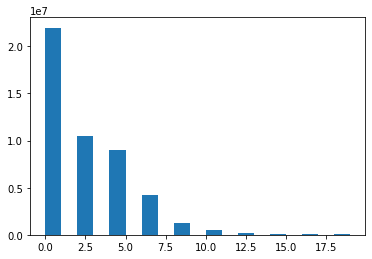

In [134]:
plt.hist(
    list(itertools.chain.from_iterable(b for b, _ in tqdm.tqdm(durs))),
    bins=range(20),
);